# Using covariates to increase precision

In [67]:
options(digits = 2)
library(foreach)
library(doMC)
registerDoMC(cores = 4)
library(ggplot2)
theme_set(theme_bw())
library(repr)
options(repr.plot.width=6, repr.plot.height=4)

Synthetic Facebook data set from https://www.udacity.com/wiki/ud651#!#data-sets.
We are working with a subset of this to make the simulations fast.

In [42]:
ps <- read.table("pseudo_facebook_small.tsv", header = TRUE)

In [72]:
dim(ps)
summary(ps$likes)
summary(ps$tenure)

[1] 10000    15

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       1      10     149      76   13600 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     229     411     539     672    2820 

# Simulate estimates under the sharp null
Simulation that computes simple difference in means and regression adjustment estimators. We use two regression adjustments: one with a single linear term and one with an interaction term with the covariate centered. See Lin (2013) in Annals of Applied Statistics.

In [73]:
do.sim <- function(x, y, nt = round(n / 2)) {
    n <- length(x)
    
    z.c <- rep(0, n)
    z.c[sample.int(n, nt)] <- 1
    
    tau.sd <- unname(coef(lm(y ~ z.c))[2])      # unadjusted
    tau.adj <- unname(coef(lm(y ~ z.c + x))[2]) # regression adjustment
    
    # interaction w centered covariate:
    x0 <- x - mean(x)
    tau.adj.int <- unname(coef(lm(y ~ z.c * x0))[2])
    
    c(th.sd = tau.sd, th.adj = tau.adj, th.adj.int = tau.adj.int)
}

Do a single simulation:

In [66]:
with(ps, do.sim(tenure, log1p(likes), nt = 2000))

th.sd     th.adj th.adj.int 
     0.051      0.060      0.059

The estimates, as we should expect, are quite similar. But we really want to compare their variance and error across many possible randomizations.

Do many simulations:

In [59]:
sr <- foreach(i = 1:1e3, .combine = rbind) %dopar%
  with(ps, do.sim(tenure, log1p(likes), nt = 2000))

In [60]:
summary(sr)

     th.sd            th.adj         th.adj.int    
 Min.   :-0.182   Min.   :-0.182   Min.   :-0.184  
 1st Qu.:-0.039   1st Qu.:-0.038   1st Qu.:-0.038  
 Median : 0.000   Median : 0.000   Median : 0.000  
 Mean   : 0.000   Mean   : 0.000   Mean   : 0.000  
 3rd Qu.: 0.038   3rd Qu.: 0.036   3rd Qu.: 0.036  
 Max.   : 0.191   Max.   : 0.190   Max.   : 0.190  

In [61]:
apply(sr, 2, sd)

th.sd     th.adj th.adj.int 
     0.058      0.057      0.057

In [62]:
apply(sr, 2, mean)

th.sd     th.adj th.adj.int 
   0.00018    0.00025    0.00030

In [63]:
rmses <- sqrt(apply(sr, 2, function(x) mean(x^2)))
rmses

th.sd     th.adj th.adj.int 
     0.058      0.057      0.057

Reduction in root mean squared error for tau:

In [64]:
1 - rmses / rmses[1]

th.sd     th.adj th.adj.int 
     0.000      0.011      0.011

This isn't much reduction. That doesn't mean there isn't clear evidence of tenure being related to likes; we can clearly detect a relationships, but mainly because we have a large N, not because there is a strong association:

In [65]:
summary(lm(log1p(likes) ~ tenure, data = ps))


Call:
lm(formula = log1p(likes) ~ tenure, data = ps)

Residuals:
   Min     1Q Median     3Q    Max 
-3.925 -2.120 -0.217  1.659  6.745 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.233249   0.033869    65.9   <2e-16 ***
tenure      0.000795   0.000048    16.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.2 on 9998 degrees of freedom
Multiple R-squared:  0.0268,	Adjusted R-squared:  0.0267 
F-statistic:  275 on 1 and 9998 DF,  p-value: <2e-16


geom_smooth: method="auto" and size of largest group is >=1000, so using gam with formula: y ~ s(x, bs = "cs"). Use 'method = x' to change the smoothing method.


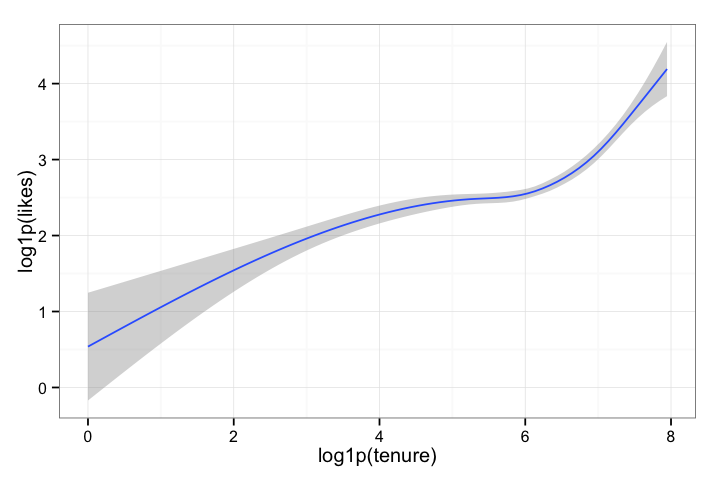

In [68]:
ggplot(
    aes(x = log1p(tenure), y = log1p(likes)),
    data = ps
) + 
geom_smooth()

## Exercises
Compare regression adjustment with post-stratification and blocking (ie pre-stratification).

Conduct similar analysis of another data set.